In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
data = pd.read_csv("Mall Customers.csv")
data

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [9]:
numerical_features = ["Spending Score (1-100)", "Annual Income (k$)", 'Age']
categorical_features = ['Gender']

In [10]:
def plot_num_cat(feature, target, figsize=None):
    # Attrition vs Age Distribution
    fig = plt.figure(figsize=(10,6))

    for value in data[target].unique():
        sns.kdeplot(data[data[target]==value][feature])

    fig.legend(labels=data[target].unique())
    plt.title('{} distribution based on {}'.format(feature, target))
    plt.show()

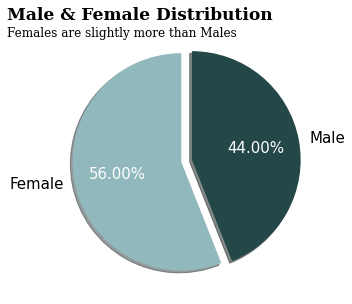

In [11]:
# looking at gender distribution
plt.figure(figsize=(5, 5))
patches, texts, autotexts = plt.pie(data['Gender'].value_counts(), autopct='%1.2f%%', 
                                    labels=data.groupby('Gender').count().reset_index()['Gender'],
                                    shadow=True, startangle=90, explode=(0.05, 0.05), colors=['#91b8bd', '#244747']);
plt.setp(texts, size=15);
plt.setp(autotexts, size=15, color='white');
plt.text(-1.65, 1.3, 'Male & Female Distribution', fontfamily='serif', fontsize=17, fontweight='bold');
plt.text(-1.65, 1.15, 'Females are slightly more than Males', fontfamily='serif', fontsize=12);
plt.show()

<Figure size 720x360 with 0 Axes>

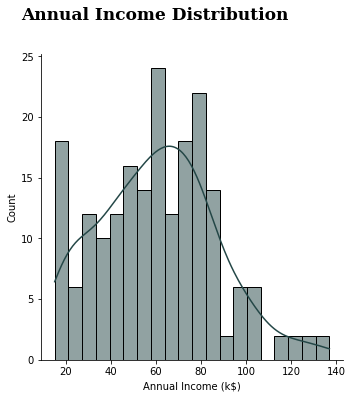

In [12]:
# Looking at annual income distribution
plt.figure(figsize=(10, 5));
sns.displot(x="Annual Income (k$)", data=data, kde=True, bins=20, color='#244747');
plt.text(0, 28, 'Annual Income Distribution', fontfamily='serif', fontsize=17, fontweight='bold');

<Figure size 720x720 with 0 Axes>

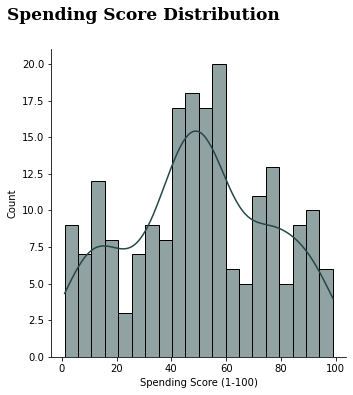

In [13]:
# looking at spending score distribution
plt.figure(figsize=(10, 10))
sns.displot(x="Spending Score (1-100)", data=data, palette='husl', kde=True, bins=20, color='#244747');
plt.text(-20, 23, 'Spending Score Distribution', fontfamily='serif', fontsize=17, fontweight='bold');
plt.show()

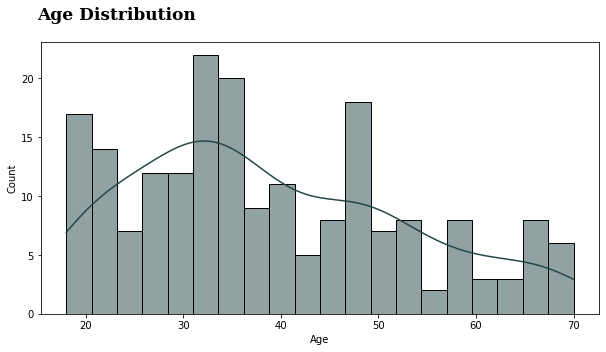

In [14]:
# looking at age distribution
plt.figure(figsize=(10,5))
sns.histplot(x="Age", data=data, palette='husl', kde=True, bins=20, color='#244747');
plt.text(15, 25, 'Age Distribution', fontfamily='serif', fontsize=17, fontweight='bold');

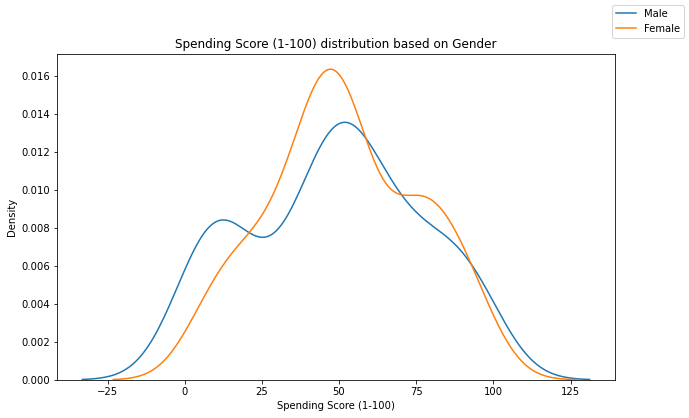

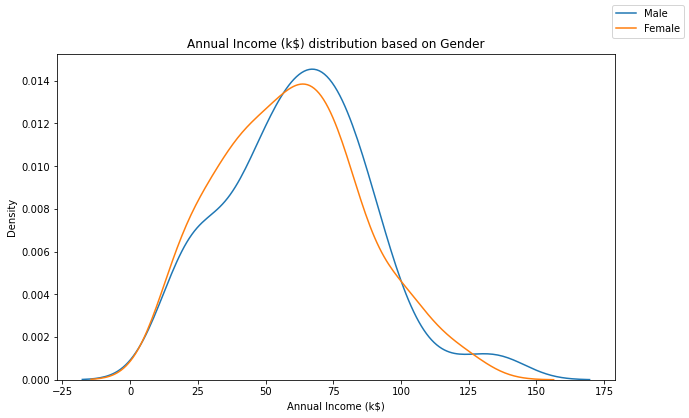

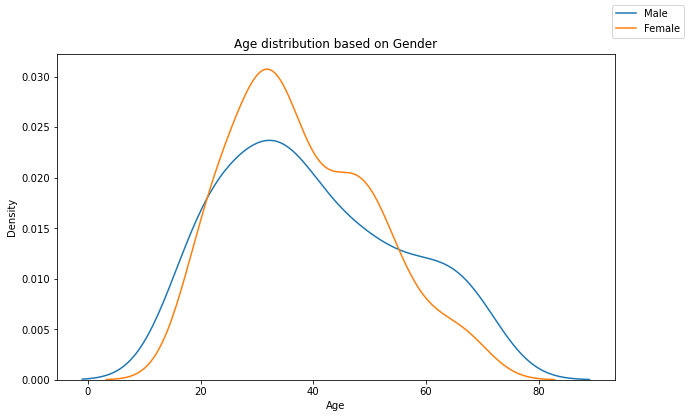

In [15]:
for feature in numerical_features:
    for target in categorical_features:
        plot_num_cat(feature, target)

## Correlation

In [22]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import joblib
import os

In [23]:
df = data.copy()
path = '/kaggle/working'
for i, feature in enumerate(categorical_features):
    le = LabelEncoder()

    if not os.path.exists(os.path.join(path, "TextEncoding")):
        os.makedirs(os.path.join(path, "TextEncoding"))

    le.fit(df[feature])

    joblib.dump(le, open(os.path.join(path, "TextEncoding/le_{}.sav".format(feature)), 'wb'))

    df[feature] = le.transform(df[feature])

    columns = list(map(lambda x: feature+' '+str(x), list(le.classes_)))[1:]

    joblib.dump(columns, 
                open(os.path.join(path, "TextEncoding/le_{}_classes.sav".format(feature)), 'wb'))

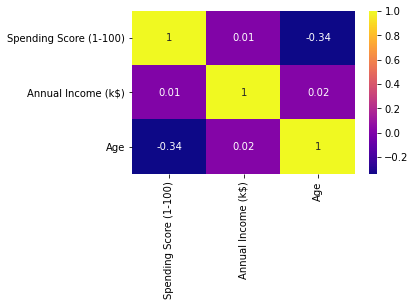

In [24]:
plt.figure(figsize=(5, 3))
sns.heatmap(round(data[numerical_features].corr(method='spearman'), 2), 
            annot=True, mask=None, cmap='plasma')
plt.show()

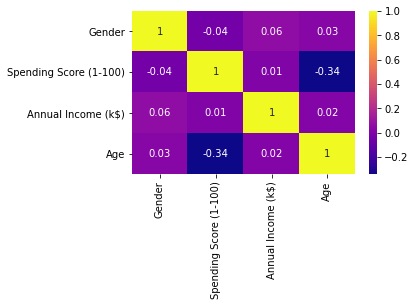

In [27]:
#Bivariate Analysis Correlation plot with the Categorical variables

plt.figure(figsize=(5, 3))
sns.heatmap(round(df[categorical_features+numerical_features].corr(method='spearman'), 2), annot=True,
            mask=None, cmap='plasma')
plt.show()

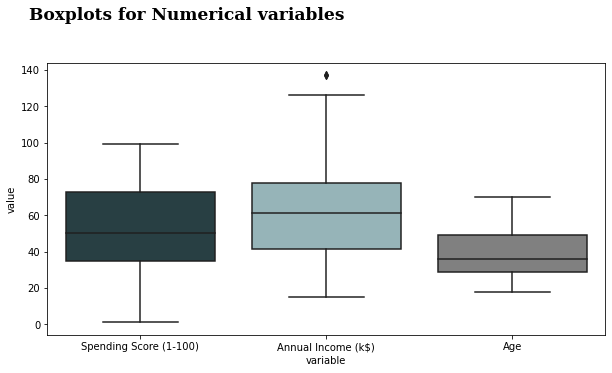

In [28]:
NumericData = data[[feature for feature in numerical_features if feature not in []]]
NumericMelt = NumericData.melt()
plt.figure(figsize=(10,5))
plt.figtext(0.1, 1, "Boxplots for Numerical variables", 
            fontfamily='serif', fontsize=17, fontweight='bold')

bp = sns.boxplot(x='variable', y='value', data=NumericMelt, 
                 palette=['#244247', '#91b8bd', 'gray'])

bp.set_xticklabels(bp.get_xticklabels(), rotation=0)
plt.show()

In [29]:
# Percentage of outliers present in each variable
outlier_percentage = {}
for feature in numerical_features:
    tempData = data.sort_values(by=feature)[feature]
    Q1, Q3 = tempData.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    Lower_range = Q1 - (1.5 * IQR)
    Upper_range = Q3 + (1.5 * IQR)
    outlier_percentage[feature] = round((((tempData<(Q1 - 1.5 * IQR)) | 
                                          (tempData>(Q3 + 1.5 * IQR))).sum()/tempData.shape[0])*100,2)
    
outlier_percentage

{'Spending Score (1-100)': 0.0, 'Annual Income (k$)': 1.0, 'Age': 0.0}

## KMeans

In [32]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [33]:
from sklearn.cluster import KMeans

feature_cols = [feature for feature in df.columns if feature not in(['Gender', 'Age'])]
train_data = df.copy()[feature_cols]
print('features used- ', feature_cols)

features used-  ['Spending Score (1-100)', 'Annual Income (k$)']


In [34]:
model = KMeans(n_clusters=5, init='k-means++', random_state=111, algorithm='elkan')
y = model.fit_predict(train_data[feature_cols])

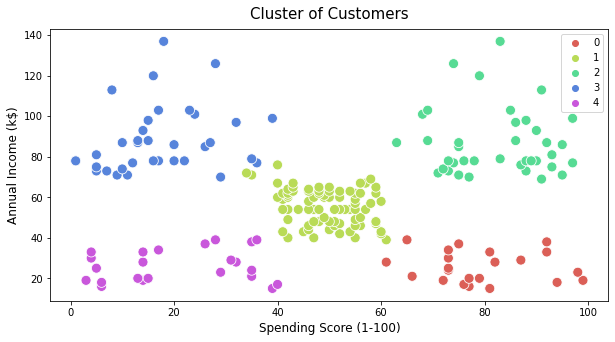

In [35]:
# Visualizing all the clusters 
plt.figure(figsize=(10,5))
sns.scatterplot(x=train_data[feature_cols[0]], y=train_data[feature_cols[1]], 
                hue=y, palette=sns.color_palette('hls', len(np.unique(y))), s=100)
plt.title('Cluster of Customers'.format(feature_cols[0], feature_cols[1]), size=15, pad=10)
plt.xlabel(feature_cols[0], size=12)
plt.ylabel(feature_cols[1], size=12)
plt.legend(loc=0, bbox_to_anchor=[1,1])
plt.show()

Model Interpretation
- Cluster 0 -> Earning low but Spending is high
- Cluster 1 -> average in terms of Earning and Spending
- Cluster 2 -> Earning high and also Spending high
- Cluster 3 -> Earning high but Spending less
- Cluster 4 -> Earning less and Spending less

## DBSCAN Model

In [83]:
from sklearn.cluster import DBSCAN

feature_cols = [feature for feature in df.columns if feature not in(['Gender', 'Age'])]
train_data = df.copy()[feature_cols]
print('features used- ', feature_cols)

features used-  ['Spending Score (1-100)', 'Annual Income (k$)']


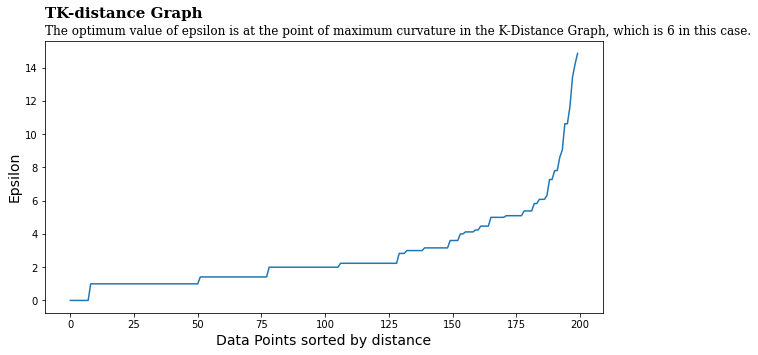

In [84]:
from sklearn.neighbors import NearestNeighbors
# finding nearest points distance for every row in data
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(train_data)
distances, indices = nbrs.kneighbors(train_data)

# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,5))
plt.text(-10, 17, 'TK-distance Graph', fontfamily='serif', fontsize=15, fontweight='bold')
plt.text(-10, 16, 'The optimum value of epsilon is max curvature in the K-Distance Graph',
        fontfamily='serif', fontsize=12)
plt.plot(distances)
plt.xlabel('Data Points sorted by distance', fontsize=14)
plt.ylabel('Epsilon', fontsize=14)
plt.show()

In [85]:
model = DBSCAN(eps=6, min_samples=3)
y = model.fit_predict(train_data)

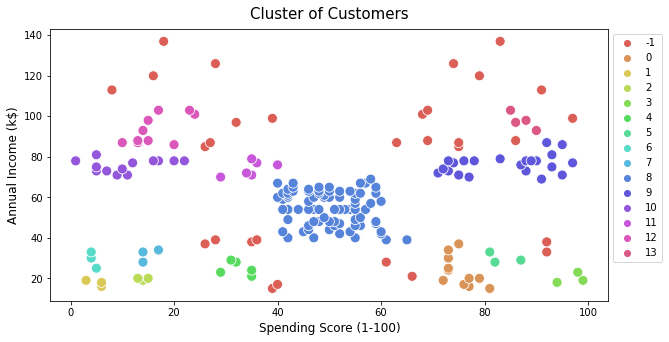

In [86]:
# Visualizing all the clusters 
plt.figure(figsize=(10,5))
sns.scatterplot(x=train_data[feature_cols[0]], y=train_data[feature_cols[1]], 
                hue=y, palette=sns.color_palette('hls', len(np.unique(y))), s=100)
plt.title('Cluster of Customers'.format(feature_cols[0], feature_cols[1]), size=15, pad=10)
plt.xlabel(feature_cols[0], size=12)
plt.ylabel(feature_cols[1], size=12)
plt.legend(loc=0, bbox_to_anchor=[1,1])
plt.show()